# Figure 2: Evolution of LERW physical networks

In [1]:
import numpy as np
import itertools
from scipy.stats import binned_statistic

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt
import matplotlib

from scipy.optimize import least_squares


Color scheme and fonts

In [2]:
colors = [
    "#3658BF",
    "#03A678",
    "#F2B705",
    "#F24141",
    "#F28705"
]

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'CMMI10'
plt.rcParams['mathtext.rm'] = 'CMR10'
plt.rcParams['mathtext.cal'] = 'CMSY10'

plt.rcParams.update({'font.size': 20})


Load networks

In [3]:
def PartLoadRWNet(filename, prefix='../data/simulations/'):
    with open(prefix+filename+".csv","rt") as f:
        next(f)
        walk_length = []
        new_sites_visited = []
        el = []
        for line in f:
            row = [int(x) for x in line.split(',')]
            if row[1]>-1:
                el.append((row[0],row[1]))
            walk_length.append(row[2])
            new_sites_visited.append(row[3])
            
    return el, walk_length, new_sites_visited

Load networks.

In [4]:
Dfs = {2:5/4, 3:1.6183, 4:2, 5:2}
walk_type='LERW'

N=1000000

In [5]:
walk_length_D = {}
el_D = {}
new_sites_visited_D = {}
for D,Df in Dfs.items():
    L  = round(N**(1/D))
    l0 = int(L**Df)
    print(D, L, L**D)
    el_D[(D,walk_type)], walk_length_D[(D,walk_type)],new_sites_visited_D[(D,walk_type)] = PartLoadRWNet(f"RWnet.{walk_type}.N{N}D{D}l0{l0}")

2 1000 1000000
3 100 1000000
4 32 1048576
5 16 1048576


### Volume-degree

Get degree sequence.

In [6]:
ks_D = {}
for key, el in el_D.items():
    el= np.array(el)
    _,ks_D[key] = np.unique(el,return_counts=True)

Calculate binned averages for plot.

In [7]:
max_v = 0
for vs in new_sites_visited_D.values():
    loc_max = max(vs)
    if max_v<loc_max:
        max_v=loc_max
        
binned_ks_D = {}
binned_vs_D = {}
bs = np.logspace(0,np.log10(max_v+1),10)
for key, el in el_D.items():
    binned_vs_D[key],_,_ = binned_statistic(new_sites_visited_D[key],new_sites_visited_D[key],statistic='mean',bins=bs)
    binned_ks_D[key],_,_ = binned_statistic(new_sites_visited_D[key],ks_D[key],statistic='mean',bins=bs)


### Degree distribution

In [8]:
uks_D = {}
ccdf_D = {}
intercept_D = {}

for key in ks_D.keys():
    ecdf = ECDF(ks_D[key],side='left')
    uks_D[key] = np.unique(ks_D[key])
    ccdf_D[key]  = 1-ecdf(uks_D[key])
    
    # for visualization, we fit the intercept using the predicted exponent
    D = key[0]
    exp = D/Dfs[D] if D<4 else 2.
    res = least_squares(lambda a: -exp*np.log(uks_D[key])+a-np.log(ccdf_D[key]), x0=2.)
    intercept_D[key]=res.x[0]

### Number of nodes in saturated state

In [9]:
Ds = [2,3,4,5]

walk_type="LERW"
LDs = np.logspace(2,20,10,base=2,dtype=int)
indep = 10

Ns_D = {}
Ls_D = {}
LDs_D = {}
Ns_std_D = {}

LDss = [LDs,LDs,LDs[1:],LDs[2:]]
for D, lds in zip(Ds,LDss):
    key = (D,walk_type)
    Ls_D[key] = []
    LDs_D[key] = []
    Ns_D[key] = []
    Ns_std_D[key] = []
    for LD in lds:
        L = round(LD**(1/D))
        Ls_D[key].append(L)
        LDs_D[key].append(L**D)
        
        l0=1
        
        ns = []
        for i in range(indep):
            _, walk_length, _ = PartLoadRWNet(f"RWnet.{walk_type}.L{L}D{D}init{l0}copy{i:02d}")
            ns.append(len(walk_length))
        
        Ns_D[key].append(np.mean(ns))
        Ns_std_D[key].append(np.std(ns))


### Final figure

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


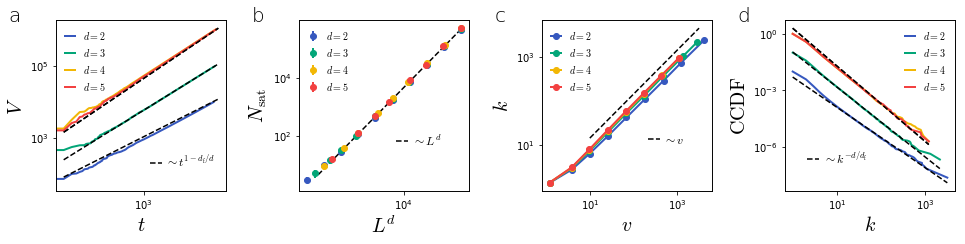

In [10]:
fig, ax = plt.subplots(1,4,figsize=(4*(3+3/8),1*(3+3/8)))
ax=ax.reshape(2,2)

#V-t
plt.sca(ax[0,0])
ts = np.logspace(0,5.8)

mult=0.01
i = 0
for D,walk_type in new_sites_visited_D.keys():
    if walk_type!='RPC':
        plt.plot(mult*np.cumsum(new_sites_visited_D[(D,walk_type)]),linewidth=2,color=colors[i],label=r"$d=%d$"%D)
        L=round(N**(1./D))
        exp = 1-Dfs[D]/D if D<4 else 1./2.
        plt.plot(ts, mult*L**D *(ts/(L**D)/exp)**exp,'k--')
        if D<4:
            mult*=10
        i+=1
        
plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=10,loc='upper left',frameon=False)
plt.xlabel(r'$t$')
plt.ylabel(r'$V$')


##Nsat-L
plt.sca(ax[0,1])

mult=0.01
i=0
for D,walk_type in Ns_D.keys():
    plt.errorbar(LDs_D[(D,walk_type)],
             Ns_D[(D,walk_type)],yerr=Ns_std_D[(D,walk_type)],fmt='o',c=colors[i],label=r"$d=%d$"%D,linewidth=2)
    mult*=10
    i+=1

xs=np.logspace(1,6)
plt.plot(xs,0.45*xs,'--k')

plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=10,loc='upper left',frameon=False)
plt.xlabel('$L^d$')
plt.ylabel(r'$N_\mathrm{sat}$')

##k-v
plt.sca(ax[1,0])

ms=.5
a=.1

mult=0.01
i=0
for D,walk_type in new_sites_visited_D.keys():
    plt.plot(binned_vs_D[(D,walk_type)],
             binned_ks_D[(D,walk_type)],'-o',c=colors[i],label=r"$d=%d$"%D,markersize=6.,linewidth=2.)
    mult*=10  
    i+=1

xs=np.logspace(1,3.5)
plt.plot(xs,1.4*xs,'--k')
        
plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=10,loc='upper left',frameon=False)
plt.xlabel(r'$v$')
plt.ylabel(r'$k$')

##CCDF
plt.sca(ax[1,1])

mult=0.01
i=0
for D,walk_type in ccdf_D.keys():
    plt.plot(uks_D[(D,walk_type)],
             mult*ccdf_D[(D,walk_type)],'-',label=r"$d=%d$"%D,c=colors[i],linewidth=2)
    
    L=round(N**(1./D))
    exp = D/Dfs[D] if D<4 else 2.
    plt.plot(uks_D[(D,walk_type)],
             mult*np.exp(intercept_D[(D,walk_type)])*uks_D[(D,walk_type)]**(-exp),'k--')
    if D<4:
        mult*=10
    i+=1

        
plt.xscale('log')
plt.yscale('log')
plt.legend(handlelength=1.,fontsize=10,loc='upper right',frameon=False)
plt.xlabel(r'$k$')
plt.ylabel(r'$\mathrm{CCDF}$')

#===========================

ax2 = ax[0,0].twinx()
ax2.plot(np.NaN,np.NaN,'k--',label=r'$\sim t^{1-d_\mathrm{f}/d}$')
ax2.get_yaxis().set_visible(False)
ax2.legend(handlelength=1.,fontsize=12,frameon=False,bbox_to_anchor=(1.,.28), handletextpad=.3)

ax2 = ax[0,1].twinx()
ax2.plot(np.NaN,np.NaN,'k--',label=r'$\sim L^d$')
ax2.get_yaxis().set_visible(False)
ax2.legend(handlelength=1.,fontsize=12,frameon=False,bbox_to_anchor=(.9,.4), handletextpad=.3)

ax2 = ax[1,0].twinx()
ax2.plot(np.NaN,np.NaN,'k--',label=r'$\sim v$')
ax2.get_yaxis().set_visible(False)
ax2.legend(handlelength=1.,fontsize=12,frameon=False,bbox_to_anchor=(.9,.4), handletextpad=.3)


ax2 = ax[1,1].twinx()
ax2.plot(np.NaN,np.NaN,'k--',label=r'$\sim k^{-d/d_\mathrm{f}}$')
ax2.get_yaxis().set_visible(False)
ax2.legend(handlelength=1.,fontsize=12,frameon=False,bbox_to_anchor=(.55,.3), handletextpad=.3)


lm =.05
bm =.2
rm =.025+lm
tm =.1+bm


plt.text(-0.28, 1.08,'a', ha='left', va='top', transform = ax[0,0].transAxes,weight='light')
plt.text(-0.28, 1.08,'b', ha='left', va='top', transform = ax[0,1].transAxes,weight='light')
plt.text(-0.28, 1.08,'c', ha='left', va='top', transform = ax[1,0].transAxes,weight='light')
plt.text(-0.28, 1.08,'d', ha='left', va='top', transform = ax[1,1].transAxes,weight='light')

for a in ax.reshape(-1):
    plt.sca(a)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


ax[0,0].set_position((0.0+lm, 0.+bm, .25-rm, 1.-tm))
ax[0,1].set_position((0.25+lm,0.+bm, .25-rm, 1.-tm))
ax[1,0].set_position((0.5+lm, 0.+bm, .25-rm, 1.-tm))
ax[1,1].set_position((0.75+lm,0.+bm ,.25-rm, 1.-tm))

plt.savefig('out.pdf')